# Lane Detection Project

In this project you need to construct computer vision solution for a lane detection. We are going to implement [LaneNet](https://arxiv.org/pdf/1802.05591.pdf) paper. Our solution is going to have the following parts:

1. Lane semantic segmentation and metric learning
2. Instance segmentation over embedings
3. Homography prediction
4. Lane fitting

We are going to use [TuSimple](https://github.com/TuSimple/tusimple-benchmark/issues/3) dataset for a lane detection.

Let's discuss every step in details.

## Semantic and Instance Segmentation

In this part you should implement and train neural network with the 2 heads. The model should take as an input image and returns to masks. One head should predict *semantic segmentation* and another head should predict *embedding for each pixel*. Pixels that are part of one lane should have similar embeddings, on the other hand pixels from different lanes should have high distance between embeddings. In order to do that, we should implement *discriminative loss*.

After training the discribed network, we can threshold pixels of the interest and cluster them according to the embedding with the *DBSCAN*.

After solving the problem you should obtain the following result.

## Homograpy Prediction

In order to solve the problem, we would like to understand an exact lane geometry. We are going to describe the lane with the 2-nd order polynom $ax^2 + bx + c$.

In the image plane lines are not parallel and we may need higher order polynoms to discribe the lane geometry. In order to avoid that we could project image in the bird's eye view with the homography. But drivable surface has different properties over frames, so we would like to condition the homography on the image.

In order to do that, we going to train separate network to predict the best homography for each image.

## Lane Fitting

After predicting homography and lane's clustering we will fit 2-nd order polynom for each lane to obtain the final result. Lane fitting can be formulated as a least-squares problem, where we have points $\{x_i, y_i\}_{i=1}^n$ and we would like to estimation coefficients $a, b, c$ s.t.

$$
\sum_{i = 1}^n ||y_i - a x_i^2 - bx_i - c||^2 \rightarrow \min_{a, b,c}
$$



## Important Notes
0. During the project we provide the relevant papers. Reading the papers can be very helpful (and sometimes necessary) to implement the code.
1. During the project we provide you with the code templates that you should fill.
2. Homography Prediction and Instance Segmentation can be done in parallel.
3. You are free to use any other environment instead of Google Colab.
4. You can deviate from the original papers if it helps you to solve the problem, but you should explain your solution and motivation in the text block.

## Semantic and Segmentation Code

You can use the following commands to download the dataset and unpack it. But we suggest to upload the data to the Google Drive, with Google Drive you will be able to access the data much faster.

Import nessesary libs

In [1]:
import json
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import torch
import torch.nn as nn
from torch.nn.modules.loss import _Loss
from torch.autograd import Variable
import tqdm

Download data

In [2]:
! pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alexkolo","key":"766780fd0a4db03158bb4b25f713b77e"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Start downloading (21.6G)

In [4]:
! kaggle datasets download -d manideep1108/tusimple

100% 21.6G/21.6G [01:30<00:00, 277MB/s]
100% 21.6G/21.6G [01:31<00:00, 255MB/s]


Unzip data

In [5]:
! mkdir data
! unzip tusimple.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/TUSimple/train_set/seg_label/0313-2/115/20.png  
  inflating: data/TUSimple/train_set/seg_label/0313-2/1150/20.png  
  inflating: data/TUSimple/train_set/seg_label/0313-2/11520/20.png  
  inflating: data/TUSimple/train_set/seg_label/0313-2/1155/20.png  
  inflating: data/TUSimple/train_set/seg_label/0313-2/11580/20.png  
  inflating: data/TUSimple/train_set/seg_label/0313-2/1160/20.png  
  inflating: data/TUSimple/train_set/seg_label/0313-2/11640/20.png  
  inflating: data/TUSimple/train_set/seg_label/0313-2/1165/20.png  
  inflating: data/TUSimple/train_set/seg_label/0313-2/1170/20.png  
  inflating: data/TUSimple/train_set/seg_label/0313-2/11700/20.png  
  inflating: data/TUSimple/train_set/seg_label/0313-2/1175/20.png  
  inflating: data/TUSimple/train_set/seg_label/0313-2/11760/20.png  
  inflating: data/TUSimple/train_set/seg_label/0313-2/1180/20.png  
  inflating: data/TUSimple/train_set/seg_label/0313-2/11820/2

In [6]:
data = []
with open("/content/data/TUSimple/train_set/label_data_0313.json") as f:
    for line in f:
        data.append(json.loads(line))

In the following cell you should implement pytorch Dataset to generate training examples for instance and semantic segmentation. You are able to modify the signatures if you want.

To implement the LaneDataset you should become familiar with the labeling format.

The dataset is relatively small, so it is important to implement different augmentation strategies. We suggest to use random flips and color augmentations (brightness, saturation). You can also use augmentations of your choice. Augmentations are not required to obtain a full grade but without them your model could overfit dramatically.

NOTE: It can be useful to generate binary segmentation and instance segmentation ground truth once and then use it as-is in every experiment.

1. **Class Definition:**
   - `LaneDataset` is a subclass of `torch.utils.data.Dataset`, representing a PyTorch dataset.

2. **`__getitem__` Method:**
   - This method retrieves an item from the dataset at a given index (`idx`).
   - It loads the corresponding image using OpenCV and resizes it to the specified image size.
   - The image is converted to grayscale, and the lanes' coordinates are obtained.
   - A segmentation image is created, where each lane is represented by a line with a specific color.
   - The segmentation image is resized, and both segmentation and instance images are converted to PyTorch tensors.

3. **`__len__` Method:**
   - This method returns the total number of items in the dataset, which is the length of the `_data` list.


In [7]:
class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=True, size=(512, 256)):
        """
        Initializes the LaneDataset.

        Args:
            dataset_path (str): Path to the dataset.
            train (bool): Whether the dataset is for training or evaluation.
            size (tuple): Image size (width, height).
        """
        self._dataset_path = dataset_path
        self._mode = "train" if train else "eval"
        self._image_size = size  # w, h

        # Define label files based on the mode
        if self._mode == "train":
            label_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0313", "0531")
            ]
        elif self._mode == "eval":
            label_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0601",)
            ]

        self._data = []

        # Process label files
        for label_file in label_files:
            with open(label_file) as f:
                for line in f:
                    info = json.loads(line)
                    image = info["raw_file"]
                    lanes = info["lanes"]
                    h_samples = info["h_samples"]
                    lanes_coords = []

                    # Process lane coordinates
                    for lane in lanes:
                        x = np.array([lane]).T
                        y = np.array([h_samples]).T
                        xy = np.hstack((x, y))
                        idx = np.where(xy[:, 0] > 0)
                        lane_coords = xy[idx]
                        lanes_coords.append(lane_coords)

                    self._data.append((image, lanes_coords))

    def __getitem__(self, idx):
        """
        Retrieves an item from the dataset.

        Args:
            idx (int): Index of the item.

        Returns:
            tuple: Tuple containing the image, segmentation image, and instance image.
        """
        image_path = os.path.join(self._dataset_path, self._data[idx][0])
        image = cv2.imread(image_path)
        h, w, c = image.shape

        # Preprocess the image
        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[..., None]
        lanes = self._data[idx][1]

        # Create segmentation image
        segmentation_image = np.zeros((h, w), dtype=np.uint8)
        for i, lane in enumerate(lanes):
            color = 1
            cv2.polylines(segmentation_image, [lane], False, color, 10)

        segmentation_image = cv2.resize(segmentation_image, self._image_size, interpolation=cv2.INTER_NEAREST)
        segmentation_image = torch.from_numpy(segmentation_image.copy()).to(torch.int64)

        # Create instance image
        instance_image = segmentation_image[..., None]

        # Convert images to PyTorch tensors
        image = torch.from_numpy(image).float().permute((2, 0, 1))
        instance_image = instance_image.permute((2, 0, 1))

        return image, segmentation_image, instance_image

    def __len__(self):
        """
        Returns the total number of items in the dataset.

        Returns:
            int: Number of items in the dataset.
        """
        return len(self._data)

In [8]:
dataset_path = "/content/data/TUSimple/train_set"
lane_dataset = LaneDataset(dataset_path=dataset_path, train=True, size=(512, 256))
im, s, ins = lane_dataset[10]
im.shape, s.shape, ins.shape

(torch.Size([1, 256, 512]), torch.Size([256, 512]), torch.Size([1, 256, 512]))

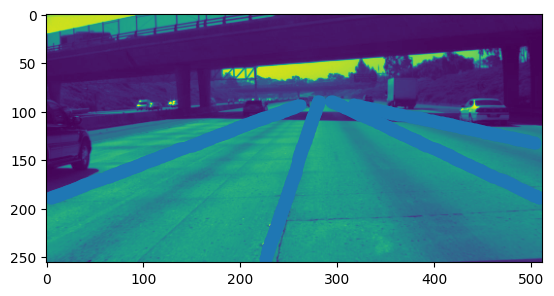

In [9]:
plt.imshow(im.squeeze())
plt.scatter(x=ins.nonzero(as_tuple=True)[2], y=ins.nonzero(as_tuple=True)[1])

For this task we are going to use ENet architecture. You can read the description in the [original paper](https://arxiv.org/pdf/1606.02147.pdf).

To generate two different outputs we need to have two different branches. In the LaneNet paper authers proposed to share only two first sections of the encoder between to tasks. Third section and decoder should be separate for the instance segmentation and binary segmentation problem.

The output dimension of the instance segmentation embedding should be equal to 5.

The `InitialBlock` represents the initial stage of a neural network and is commonly found at the beginning of architectures like ENet.

1. **Constructor (`__init__` method):**
   - The constructor initializes the parameters and components of the `InitialBlock`.
   - It takes the following arguments:
     - `in_channels`: Number of input channels.
     - `out_channels`: Number of output channels for the block.
     - `bias`: Boolean indicating whether to use bias in convolutional layers (default is `False`).
     - `relu`: Boolean indicating whether to use ReLU activation or PReLU activation (default is `True`).


2. **Forward Method (`forward` method):**
   - The `forward` method defines the forward pass of the `InitialBlock`.
   - It takes an input tensor `x` and passes it through both the main and extension branches.
   - The outputs of the main and extension branches are concatenated along the channel dimension (`dim=1`).
   - Batch normalization is applied to the concatenated tensor.
   - The final activation function is applied to the normalized tensor, and the result is returned.

In [10]:
class InitialBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        # Choose activation function based on the 'relu' parameter
        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - Output channels for this branch is out_channels - 1
        # as the remaining channel comes from the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 1,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch - Max pooling with kernel size 3, stride 2, and padding 1
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Batch normalization to be applied after concatenation of branches
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # Activation function to be applied after concatenation
        self.out_activation = activation()

    def forward(self, x):
        # Forward pass through the main and extension branches
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate the output of the main and extension branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        # Apply the final activation function
        return self.out_activation(out)


This module represents a building block commonly used in deep neural networks, particularly in convolutional neural networks (CNNs). The `RegularBottleneck` consists of a main branch (shortcut connection) and an extension branch. It is designed to be used in the context of a larger neural network architecture.

Here is an explanation of the code:

1. The `__init__` method initializes the `RegularBottleneck` module with various parameters:
   - `channels`: The number of input channels.
   - `internal_ratio`: A ratio used to compute the number of internal channels (channels within the bottleneck).
   - `kernel_size`: Size of the convolutional kernel.
   - `padding`: Padding applied to the input.
   - `dilation`: Dilation factor for the convolution.
   - `asymmetric`: A boolean flag indicating whether to use asymmetric convolution.
   - `dropout_prob`: Probability of spatial dropout.
   - `bias`: A boolean flag indicating whether to include bias terms in the convolutional layers.
   - `relu`: A boolean flag indicating whether to use ReLU activation (otherwise PReLU).

2. The main branch (`main`) is the shortcut connection, where the input tensor `x` is directly passed through without any modifications.

3. The extension branch (`ext`) consists of the following operations:
   - A 1x1 projection convolution (`ext_conv1`) followed by batch normalization and activation.
   - An optional asymmetric convolution (`ext_conv2`) if the `asymmetric` flag is set, otherwise a regular convolution, followed by batch normalization and activation.
   - A 1x1 expansion convolution (`ext_conv3`) followed by batch normalization and activation.
   - A 2D dropout regularization (`ext_regul`) with a specified dropout probability.

4. The output of the extension branch is added element-wise to the main branch.

5. The final output is passed through another activation function (`out_activation`), which is a PReLU or ReLU depending on the `relu` parameter.

6. The `forward` method defines the forward pass of the module, where the input tensor `x` undergoes the operations described above, and the final output is returned.


In [11]:
class RegularBottleneck(nn.Module):
    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)

Similar to the previous code, this module represents a building block used in deep neural networks, particularly in the context of downsampling (e.g., in encoder parts of CNNs).

Here is an explanation of the code:

1. The `__init__` method initializes the `DownsamplingBottleneck` module with various parameters:
   - `in_channels`: The number of input channels.
   - `out_channels`: The number of output channels.
   - `internal_ratio`: A ratio used to compute the number of internal channels (channels within the bottleneck).
   - `return_indices`: A boolean flag indicating whether to return the indices from the max pooling operation.
   - `dropout_prob`: Probability of spatial dropout.
   - `bias`: A boolean flag indicating whether to include bias terms in the convolutional layers.
   - `relu`: A boolean flag indicating whether to use ReLU activation (otherwise PReLU).

2. The `return_indices` parameter is stored for later use.

3. A check is performed to ensure that the `internal_ratio` parameter is within the expected range [1, in_channels].

4. The main branch (`main`) consists of max pooling with a 2x2 kernel and stride 2. This operation downsamples the input tensor.

5. The extension branch (`ext`) consists of the following operations:
   - A 2x2 projection convolution with stride 2 (`ext_conv1`) followed by batch normalization and activation.
   - A 3x3 convolution (`ext_conv2`) followed by batch normalization and activation.
   - A 1x1 expansion convolution (`ext_conv3`) followed by batch normalization and activation.
   - A 2D dropout regularization (`ext_regul`) with a specified dropout probability.

6. If `return_indices` is `True`, the indices from the max pooling operation are also returned.

7. The main branch undergoes feature map padding to match the channel dimensions of the extension branch. This ensures compatibility for concatenation.

8. The main and extension branches are concatenated along the channel dimension.

9. The final output is the element-wise sum of the main and extension branches.

10. The output is passed through another activation function (`out_activation`), which is a PReLU or ReLU depending on the `relu` parameter.

11. If `return_indices` is `True`, the output includes the max pooling indices; otherwise, it is `None`.


In [12]:
class DownsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check if the internal_ratio parameter is within the expected range [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        # Choose activation function based on the 'relu' parameter
        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated, or
        # asymmetric convolution, followed by another 1x1 convolution. The number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        # Dropout regularization for the extension branch
        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # Activation function to be applied after concatenation
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices if self.return_indices else None

This module represents a building block commonly used in the upsampling part of deep neural networks, typically in the decoder part of autoencoders or in architectures like U-Net.

Here is an explanation of the code:

1. The `__init__` method initializes the `UpsamplingBottleneck` module with various parameters:
   - `in_channels`: The number of input channels.
   - `out_channels`: The number of output channels.
   - `internal_ratio`: A ratio used to compute the number of internal channels (channels within the bottleneck).
   - `dropout_prob`: Probability of spatial dropout.
   - `bias`: A boolean flag indicating whether to include bias terms in the convolutional layers.
   - `relu`: A boolean flag indicating whether to use ReLU activation (otherwise PReLU).

2. A check is performed to ensure that the `internal_ratio` parameter is within the expected range [1, in_channels].

3. The main branch (`main`) consists of:
   - A 1x1 convolution (`main_conv1`) followed by batch normalization.
   - A max unpooling layer (`main_unpool1`) with a kernel size of 2. This is used for upsampling and requires the max pooling indices (`max_indices`) and the output size (`output_size`).

4. The extension branch (`ext`) consists of the following operations:
   - A 1x1 convolution (`ext_conv1`) followed by batch normalization and activation.
   - A 2x upsampling (transposed convolution) operation (`ext_tconv1`) with a kernel size of 2 and stride of 2.
   - Batch normalization (`ext_tconv1_bnorm`) and activation (`ext_tconv1_activation`) after the transposed convolution.
   - Another 1x1 convolution (`ext_conv2`) followed by batch normalization and activation.
   - A 2D dropout regularization (`ext_regul`) with a specified dropout probability.

5. The main and extension branches are added element-wise.

6. The final output is passed through another activation function (`out_activation`), which is a PReLU or ReLU depending on the `relu` parameter.

7. The forward method takes three parameters: `x` (the input tensor), `max_indices` (indices from the max pooling operation in the corresponding downsampling step), and `output_size` (the size of the output tensor after upsampling). The main and extension branches are computed using the specified operations, and the final output is returned.


In [13]:
import torch
import torch.nn as nn

class UpsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check if the internal_ratio parameter is within the expected range [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        # Choose activation function based on the 'relu' parameter
        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - 1x1 convolution followed by batch normalization
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Max unpooling layer with kernel size 2
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, transposed convolution, and 1x1 convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation())

        # Dropout regularization for the extension branch
        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # Activation function to be applied after concatenation
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)

ENet is a deep neural network architecture designed for efficient real-time semantic segmentation. It consists of an initial block, several shared stages, and branches for binary segmentation and instance embedding.

1. The `__init__` method initializes the `ENet` model with the following parameters:
   - `binary_seg`: The number of output channels for binary segmentation.
   - `embedding_dim`: The dimension of the output for instance embedding.
   - `encoder_relu`: A boolean flag indicating whether to use ReLU activation in the encoder.
   - `decoder_relu`: A boolean flag indicating whether to use ReLU activation in the decoder.

2. The model consists of an initial block (`initial_block`) and three shared stages (`downsample1_0`, `downsample2_0`, and the following regular and dilated/asymmetric convolutions). It also includes separate branches for binary segmentation and instance embedding.

3. The binary segmentation branch consists of a series of regular, dilated, and asymmetric convolutions (`regular_binary_3_*`, `dilated_binary_3_*`, `asymmetric_binary_3_*`) in the third shared stage, followed by upsampling and additional regular convolutions in the decoder (`upsample_binary_4_*`, `regular_binary_4_*`, `upsample_binary_5_*`, `regular_binary_5_*`). The final output is produced by a transposed convolution (`binary_transposed_conv`).

4. The instance embedding branch follows a similar structure, with convolutions in the third shared stage (`regular_embedding_3_*`, `dilated_embedding_3_*`, `asymmetric_embedding_3_*`), upsampling and additional regular convolutions in the decoder (`upsample_embedding_4_*`, `regular_embedding_4_*`, `upsample_embedding_5_*`, `regular_embedding_5_*`), and a transposed convolution (`embedding_transposed_conv`) for the final output.

5. The `forward` method defines the forward pass of the model. The input tensor `x` undergoes the operations described in the initializer for the initial block and each shared stage. The results of the third shared stage are then used as inputs for both the binary segmentation and instance embedding branches. The branches include upsampling and additional convolutions in the decoder. The final outputs for binary segmentation and instance embedding are returned.


In [14]:
class ENet(nn.Module):
    def __init__(self, binary_seg, embedding_dim, encoder_relu=False, decoder_relu=True):
        super(ENet, self).__init__()

        # Initial block
        self.initial_block = InitialBlock(1, 16, relu=encoder_relu)

        # Stage 1 share
        self.downsample1_0 = DownsamplingBottleneck(16, 64, return_indices=True, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 share
        self.downsample2_0 = DownsamplingBottleneck(64, 128, return_indices=True, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 binary
        self.regular_binary_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_binary_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 embedding
        self.regular_embedding_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_embedding_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_embedding_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_bembedding_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # binary branch
        self.upsample_binary_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_binary_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.binary_transposed_conv = nn.ConvTranspose2d(16, binary_seg, kernel_size=3, stride=2, padding=1, bias=False)

        # embedding branch
        self.upsample_embedding_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_embedding_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.embedding_transposed_conv = nn.ConvTranspose2d(16, embedding_dim, kernel_size=3, stride=2, padding=1, bias=False)

    def forward(self, x):
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 share
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 share
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # stage 3 binary
        x_binary = self.regular_binary_3_0(x)
        x_binary = self.dilated_binary_3_1(x_binary)
        x_binary = self.asymmetric_binary_3_2(x_binary)
        x_binary = self.dilated_binary_3_3(x_binary)
        x_binary = self.regular_binary_3_4(x_binary)
        x_binary = self.dilated_binary_3_5(x_binary)
        x_binary = self.asymmetric_binary_3_6(x_binary)
        x_binary = self.dilated_binary_3_7(x_binary)

        # stage 3 embedding
        x_embedding = self.regular_embedding_3_0(x)
        x_embedding = self.dilated_embedding_3_1(x_embedding)
        x_embedding = self.asymmetric_embedding_3_2(x_embedding)
        x_embedding = self.dilated_embedding_3_3(x_embedding)
        x_embedding = self.regular_embedding_3_4(x_embedding)
        x_embedding = self.dilated_embedding_3_5(x_embedding)
        x_embedding = self.asymmetric_bembedding_3_6(x_embedding)
        x_embedding = self.dilated_embedding_3_7(x_embedding)

        # binary branch
        x_binary = self.upsample_binary_4_0(x_binary, max_indices2_0, output_size=stage2_input_size)
        x_binary = self.regular_binary_4_1(x_binary)
        x_binary = self.regular_binary_4_2(x_binary)
        x_binary = self.upsample_binary_5_0(x_binary, max_indices1_0, output_size=stage1_input_size)
        x_binary = self.regular_binary_5_1(x_binary)
        binary_final_logits = self.binary_transposed_conv(x_binary, output_size=input_size)

        # embedding branch
        x_embedding = self.upsample_embedding_4_0(x_embedding, max_indices2_0, output_size=stage2_input_size)
        x_embedding = self.regular_embedding_4_1(x_embedding)
        x_embedding = self.regular_embedding_4_2(x_embedding)
        x_embedding = self.upsample_embedding_5_0(x_embedding, max_indices1_0, output_size=stage1_input_size)
        x_embedding = self.regular_embedding_5_1(x_embedding)
        instance_final_logits = self.embedding_transposed_conv(x_embedding, output_size=input_size)

        return binary_final_logits, instance_final_logits

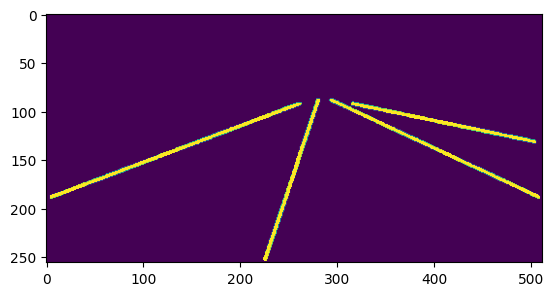

In [15]:
test_input = torch.ones((1, 1, 256, 512))
net = ENet(2, 4)
binary, instance = net(test_input)
s_pred, ins_pred = net(im[None, ...])
plt.imshow(ins.squeeze())

To obtain the instance segmentation we should train the embeddings as we described in the project description. In order to do that we need to implement [Discriminative Loss](https://arxiv.org/pdf/1708.02551.pdf). Discriminative loss consists of three parts:

1. Inter-cluster push-force: cluster means should be far away from each other
2. Intra-cluster pull-force: embeddings should be close to the center of the corresponding cluster.
3. Regularization: cluster centers should be close to zero.

Corresponding weights for the losses and other hyper-parameters could be found in the paper.

This loss is designed for semantic segmentation tasks and aims to encourage discriminative clustering of embeddings while minimizing within-cluster variance.


1. **Initialization (`__init__` method):**
   - `delta_var`: Threshold for within-cluster variance.
   - `delta_dist`: Threshold for inter-cluster distance.
   - `norm`: Norm used for distance calculations (1 or 2).
   - `alpha`: Weight for within-cluster variance term.
   - `beta`: Weight for inter-cluster distance term.
   - `gamma`: Weight for mean cluster regularization term.
   - `device`: Device to use (e.g., "cpu" or "cuda").
   - `reduction`: Specifies the reduction to apply to the output (default is "mean").
   - `n_clusters`: Number of clusters.

2. **Assertions:**
   - The `norm` parameter must be 1 or 2, and an assertion is used to ensure this.

3. **Forward Pass (`forward` method):**
   - The forward method is overridden from the `_Loss` class, and it calls the `_discriminative_loss` method to compute the loss.

4. **Discriminative Loss Calculation (`_discriminative_loss` method):**
   - The function calculates three components of the discriminative loss: within-cluster variance (`var_loss`), inter-cluster distance (`dis_loss`), and mean cluster regularization (`reg_loss`).
   - It iterates through each sample in the batch.
   - For each sample, it iterates through each unique cluster in the segmentation map.
   - It calculates the within-cluster variance, inter-cluster distance, and mean cluster regularization for each cluster and accumulates these values.
   - Finally, it computes the total loss by combining the three components with the specified weights (`alpha`, `beta`, `gamma`).

5. **Loss Components Calculation:**
   - `v_loss`: Accumulates the within-cluster variance for each cluster.
   - `r_loss`: Accumulates the mean cluster regularization term for each cluster.
   - `d_loss`: Accumulates the inter-cluster distance for each pair of clusters.

6. **Loss Normalization:**
   - The accumulated losses (`var_loss`, `dis_loss`, `reg_loss`) are normalized by the number of clusters and the number of samples in the batch.

7. **Return:**
   - The final loss is returned as a weighted sum of the normalized within-cluster variance, inter-cluster distance, and mean cluster regularization.


In [16]:
class DiscriminativeLoss(_Loss):
    def __init__(self, delta_var=0.5, delta_dist=3,
                 norm=2, alpha=1.0, beta=1.0, gamma=0.001,
                 device="cpu", reduction="mean", n_clusters=4):
        """
        Initializes the Discriminative Loss.

        Args:
            delta_var (float): Threshold for within-cluster variance.
            delta_dist (float): Threshold for inter-cluster distance.
            norm (int): Norm used for distance calculations (1 or 2).
            alpha (float): Weight for within-cluster variance term.
            beta (float): Weight for inter-cluster distance term.
            gamma (float): Weight for mean cluster regularization term.
            device (str): Device to use (e.g., "cpu" or "cuda").
            reduction (str): Specifies the reduction to apply to the output.
            n_clusters (int): Number of clusters.

        Raises:
            AssertionError: If norm is not 1 or 2.
        """
        super(DiscriminativeLoss, self).__init__(reduction=reduction)
        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.device = torch.device(device)
        self.n_clusters = n_clusters
        assert self.norm in [1, 2]

    def forward(self, input, target):
        """
        Calculates the Discriminative Loss.

        Args:
            input (torch.Tensor): Input tensor.
            target (torch.Tensor): Target tensor.

        Returns:
            torch.Tensor: Discriminative Loss.
        """
        assert not target.requires_grad
        return self._discriminative_loss(input, target)

    def _discriminative_loss(self, input, target):
        """
        Calculates the components of the Discriminative Loss.

        Args:
            input (torch.Tensor): Input tensor.
            target (torch.Tensor): Target tensor.

        Returns:
            torch.Tensor: Discriminative Loss.
        """
        num_samples = target.size(0)

        dis_loss = torch.tensor(0.).to(self.device)
        var_loss = torch.tensor(0.).to(self.device)
        reg_loss = torch.tensor(0.).to(self.device)

        for i in range(num_samples):
            clusters = []
            sample_embedding = input[i, :, :, :]
            sample_label = target[i, :, :].squeeze()
            num_clusters = len(sample_label.unique()) - 1
            vals = sample_label.unique()[1:]
            sample_label = sample_label.view(sample_label.size(0) * sample_label.size(1))
            sample_embedding = sample_embedding.view(-1, sample_embedding.size(1) * sample_embedding.size(2))

            v_loss = torch.tensor(0.).to(self.device)
            d_loss = torch.tensor(0.).to(self.device)
            r_loss = torch.tensor(0.).to(self.device)

            for j in range(num_clusters):
                indices = (sample_label == vals[j]).nonzero()
                indices = indices.squeeze()
                cluster_elements = torch.index_select(sample_embedding, 1, indices)
                Nc = cluster_elements.size(1)
                mean_cluster = cluster_elements.mean(dim=1, keepdim=True)
                clusters.append(mean_cluster)

                v_loss += torch.pow((torch.clamp(torch.norm(cluster_elements - mean_cluster) - self.delta_var, min=0.)), 2).sum() / Nc
                r_loss += torch.sum(torch.abs(mean_cluster))

            for index in range(num_clusters):
                for idx, cluster in enumerate(clusters):
                    if index == idx:
                        continue
                    else:
                        distance = torch.norm(clusters[index] - cluster)
                        d_loss += torch.pow(torch.clamp(self.delta_dist - distance, min=0.), 2)

            var_loss += v_loss / num_clusters
            dis_loss += d_loss / (num_clusters * (num_clusters - 1))
            reg_loss += r_loss / num_clusters

        return self.alpha * (var_loss / num_samples) + self.beta * (dis_loss / num_samples) + self.gamma * (reg_loss / num_samples)

In [17]:
DiscriminativeLoss(delta_var=0.5, delta_dist=3, alpha=1.0, beta=1.0, gamma=0.001)(ins_pred, ins)

tensor(nan, grad_fn=<AddBackward0>)

In [18]:
def compute_loss(binary_output, instance_output, binary_label, instance_label):
    ce_loss = nn.CrossEntropyLoss()
    binary_loss = ce_loss(binary_output, binary_label)

    ds_loss = DiscriminativeLoss(delta_var=0.5, delta_dist=3, alpha=1.0, beta=1.0, gamma=0.001, device="cuda")
    instance_loss = ds_loss(instance_output, instance_label)

    return binary_loss, instance_loss

Now we are ready to train the network. You may want to create validation subset to track metrics.

1. **Constants and Hyperparameters:**
   - `BATCH_SIZE`: Number of samples in each training batch.
   - `LR`: Learning rate for the Adam optimizer.
   - `NUM_EPOCHS`: Number of training epochs.
   - `dataset_path`: Path to the training dataset.

2. **Model Initialization:**
   - An instance of the `ENet` model is created with two output channels for binary segmentation and four channels for instance embedding.

3. **Optimizer Configuration:**
   - The Adam optimizer is used to update the model parameters during training. Only the parameters that require gradients are optimized.

4. **Training Loop:**
   - The training loop iterates over the specified number of epochs (`NUM_EPOCHS`).
   - Inside each epoch, the model is set to training mode (`enet_model.train()`).
   - The loop iterates through batches of data from the training data loader using `tqdm.tqdm` for progress tracking.
   - For each batch, the input image (`img`), binary target, and instance target are moved to the selected device.
   - The optimizer gradients are zeroed using `optimizer.zero_grad()`.
   - Forward pass: The model is used to obtain binary logits and instance embeddings for the input image.
   - Loss computation: The binary and instance losses are calculated using a custom `compute_loss` function (not provided in the code snippet). These losses are then added to obtain the total loss.
   - Backward pass: The gradients are computed using `loss.backward()` to perform backpropagation.
   - Optimization step: The optimizer takes a step to update the model parameters using the computed gradients.
   - The losses for each batch are recorded.

5. **Epoch Summary:**
   - After each epoch, the mean binary and instance losses are calculated using the losses accumulated over batches.
   - A message is printed summarizing the epoch number and the mean losses.


In [19]:
import tqdm

BATCH_SIZE = 12
LR = 1e-3
NUM_EPOCHS = 25 #25

dataset_path = "/content/data/TUSimple/train_set"
train_dataset = LaneDataset(dataset_path=dataset_path)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

enet_model = ENet(2, 4)
enet_model.to(device)

params = [p for p in enet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=LR, weight_decay=0.0002)

train_losses = []

for epoch in range(NUM_EPOCHS):
    enet_model.train()
    losses = []
    for batch in tqdm.tqdm(train_dataloader):
        img, binary_target, instance_target = batch
        img = img.to(device)
        binary_target = binary_target.to(device)
        instance_target = instance_target.to(device)

        optimizer.zero_grad()

        binary_logits, instance_emb = enet_model(img)

        binary_loss, instance_loss = compute_loss(binary_logits, instance_emb, binary_target, instance_target)
        loss = binary_loss + instance_loss
        loss.backward()

        optimizer.step()

        losses.append((binary_loss.detach().cpu(), instance_loss.detach().cpu()))

    mean_losses = np.array(losses).mean(axis=0)

    msg = (f"Epoch {epoch}:"
          f"loss = {mean_losses}")
    print(msg)

100%|██████████| 268/268 [01:16<00:00,  3.50it/s]


Epoch 0:loss = [0.23662816        nan]


100%|██████████| 268/268 [01:14<00:00,  3.62it/s]


Epoch 1:loss = [0.06173544        nan]


100%|██████████| 268/268 [01:14<00:00,  3.62it/s]


Epoch 2:loss = [0.05192547        nan]


100%|██████████| 268/268 [01:13<00:00,  3.63it/s]


Epoch 3:loss = [0.04765622        nan]


100%|██████████| 268/268 [01:13<00:00,  3.63it/s]


Epoch 4:loss = [0.04526807        nan]


100%|██████████| 268/268 [01:13<00:00,  3.63it/s]


Epoch 5:loss = [0.04399893        nan]


100%|██████████| 268/268 [01:13<00:00,  3.63it/s]


Epoch 6:loss = [0.04300087        nan]


100%|██████████| 268/268 [01:13<00:00,  3.63it/s]


Epoch 7:loss = [0.0422202       nan]


100%|██████████| 268/268 [01:14<00:00,  3.62it/s]


Epoch 8:loss = [0.04154571        nan]


100%|██████████| 268/268 [01:13<00:00,  3.63it/s]


Epoch 9:loss = [0.04113493        nan]


100%|██████████| 268/268 [01:13<00:00,  3.62it/s]


Epoch 10:loss = [0.04062098        nan]


100%|██████████| 268/268 [01:13<00:00,  3.62it/s]


Epoch 11:loss = [0.04031322        nan]


100%|██████████| 268/268 [01:13<00:00,  3.63it/s]


Epoch 12:loss = [0.04004078        nan]


100%|██████████| 268/268 [01:13<00:00,  3.63it/s]


Epoch 13:loss = [0.03977042        nan]


100%|██████████| 268/268 [01:14<00:00,  3.62it/s]


Epoch 14:loss = [0.03940527        nan]


100%|██████████| 268/268 [01:13<00:00,  3.63it/s]


Epoch 15:loss = [0.03937967        nan]


100%|██████████| 268/268 [01:13<00:00,  3.63it/s]


Epoch 16:loss = [0.03912681        nan]


100%|██████████| 268/268 [01:13<00:00,  3.64it/s]


Epoch 17:loss = [0.0389594       nan]


100%|██████████| 268/268 [01:13<00:00,  3.63it/s]


Epoch 18:loss = [0.03877043        nan]


100%|██████████| 268/268 [01:13<00:00,  3.64it/s]


Epoch 19:loss = [0.03871878        nan]


100%|██████████| 268/268 [01:13<00:00,  3.63it/s]


Epoch 20:loss = [0.03858164        nan]


100%|██████████| 268/268 [01:13<00:00,  3.65it/s]


Epoch 21:loss = [0.03838321        nan]


100%|██████████| 268/268 [01:13<00:00,  3.64it/s]


Epoch 22:loss = [0.03857265        nan]


100%|██████████| 268/268 [01:13<00:00,  3.64it/s]


Epoch 23:loss = [0.0382635       nan]


100%|██████████| 268/268 [01:13<00:00,  3.63it/s]

Epoch 24:loss = [0.03817564        nan]


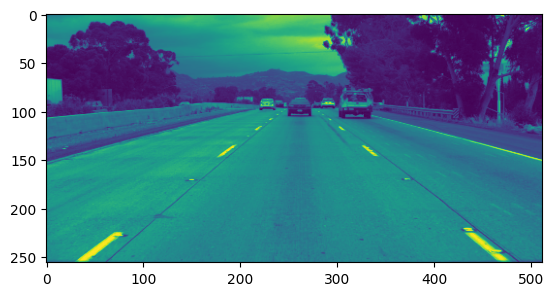

In [20]:
enet_eval_dataset = LaneDataset(dataset_path=dataset_path, train=False)
enet_eval_img_10, *_ = enet_eval_dataset[0]
enet_eval_img_10 = enet_eval_img_10.to(device)
binary_logits, instance_emb = enet_model(enet_eval_img_10[None, ...])
enet_eval_img_10.shape, binary_logits.shape, instance_emb.shape

plt.imshow(enet_eval_img_10.squeeze().cpu())

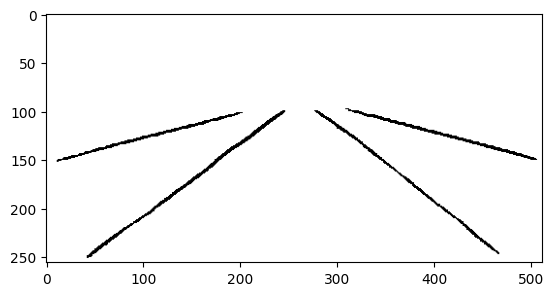

In [21]:
plt.imshow(binary_logits.squeeze().argmax(axis=0).cpu(), cmap=plt.cm.binary)

## Homograpy Prediction Code

Here we again need to implement the Dataset class. Dataset class should return resized image and ground truth points for the lane trajectories.


In [ ]:
HNET_DEFAULT_SIZE = (64, 128)
import torch

class HomographyPredictionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=True, size=DEFAULT_SIZE):
        # TODO
        pass

    def __getitem__(self, idx):
        # TODO
        return image, ground_truth_trajectory

    def __len__(self):
        # TODO
        pass

Now we need to implement the H-Net. It should return homography matrix that is parametrized by 6 numbers.
Corresponding section is CURVE FITTING USING H-NET in the[ LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

We suggest to follow the paper and take 64x128 image as in input.

Homography projection contains discontinuities, therefore it could be quite difficult to train the network. In order to simplify the problem we propose not to train the homography from scratch, but train some correction to a good starting point.

The following code block contains the initial homography that you can use.


In [ ]:
import torch

# important note: this homography matrix is suitable only for 64x128 resolution
R = torch.Tensor([[-2.0484e-01, -1.7122e+01,  3.7991e+02],
                  [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
                  [ 0.0000e+00, -4.6739e-02,  1.0000e+00]])

Let's check the effect of this homography on the image.

In [ ]:
# !wget https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg

In [ ]:
from matplotlib import pyplot as plt
import cv2

In [ ]:
image = plt.imread('1*b3HiwPg69Rw0L5iIMQMXOw.jpeg')

In [ ]:
image = cv2.resize(image, (128, 64))

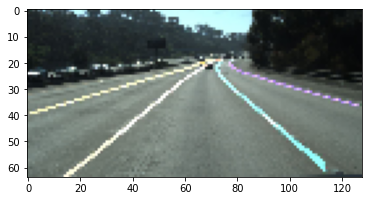

In [ ]:
plt.imshow(image)

In [ ]:
R_np = R.numpy()

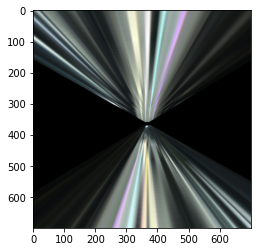

In [ ]:
plt.imshow(cv2.warpPerspective(image, R_np, dsize=(700, 700)))

As you can see it looks like a bird's eye view projection where lines are becoming parallel.

In [ ]:
class HNet(nn.Module):
    def __init__(self):
        super(HNet, self).__init__()
        # TODO
    def forward(self, x):
      # TODO
      pass

Finally, we need to implement the loss to fit the network. This is the most difficult part of the project. Homography loss should do the following:

1. Project ground truth trajectory to the new plane according to the homography to obtain $(x', y')$.
2. Perform polynomial fitting $x' = f(y')$. Your code should work correctly with 2-nd and 3-rd order polynomials. Polynomial fitting should be done with the closed-form solution: $w = (Y^TY)^{-1}Y^Tx$ to be able to pass a gradient through.
3. Compute back projection with the inverse homography.
4. Compute loss between back projected $\hat{x}$ and ground truth $x$.

The full description can be found in the [LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

**IMPORTANT NOTES**

* To fit the polynomial you need to compute the inverse matrix. Computation of the inverse is computation unstable operation. With the help of the SVD you can compute pseudo-inverse matrix: $(X^TX)^{-1}X^T$. In torch this function is called `torch.pinverse`.
* After projection use of the raw $y'$ can be impractical. The features for the polynomial fitting could have a high correlation and therefore solution can be unstable. At first, you need to map $y'$ to some fixed size segment and only then perform a fit.
* After projection some points can occur on the other side of image (bottom part of the projection in the example above). You may want to exclude them, because otherwise polynomial is not going to have much sense and gradients can have a dramatically large values. Positive $w$ in homogeneous coordinates indicates that point is on the wrong side.
* If use the homography provided above, your ground truth should have the same scale, as an image
* Every division in your network is a potential place to obtain `nan` in gradients. Use the following trick to obtain less divisions:
after computing the projection, remember the $w$. Then, before the back projection, multiply your vector by $w$. After back projection you will see that $w$ is equal to 1. So you don't need to devide your vector by $w$.
* You correction to the initial homography could be very big and can completely spoil the homography. So you may need to scale the output of the last layer in the HNet to obtain a smaller corrections.


In [ ]:
class HomographyLoss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=True):
        super(HomographyLoss, self).__init__(size_average=size_average)

    def forward(self, input, target):
        # TODO
        pass

Finally, train the homography net with the 2-nd order polynomial fitting (you can 3-rd order but we found out that it is much easier to train h-net with the 2-nd order polynomials).

We found out that SGD fits much better for this architectures. Adam (and momentums inside) can ruin the weights because of the discontinuities in the target function surface.

Demonstrate the difference in homography loss between h-net and provided fixed homography on the validation samples.

In [ ]:
# Train the H-Net

# Complete Pipeline

Now you need to implement a class that takes image and a set of $y$ coordinates as an input and returns the $x$ coordinate for each lane in this image.

It should contain the following steps:

1. Apply segmentation network to the image
2. Run DBSCAN over the embeddings for those pixels that are lanes.
3. Apply h-net to the image
4. Project pixel coordinates with the predicted homograpgy
5. Fit the 3-rd order polynomial
6. Predict the lane position for each provided $y$ (you should project this first).
7. Compute back projection and return the positions of $x$ for each lane.

Note: if you weren't able to train the H-Net, you can use the fixed homography here.

In [ ]:
class LaneDetector:
  def __init__(self, hnet, lanenet):
    pass

  def __call__(self, image, y_positions):
    pass